In [1]:
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [3]:
# Cell 2: Mount Google Drive (Original Code)
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [4]:
import os

path = os.listdir('/kaggle/input/new-plant-diseases-dataset')

In [5]:
path

['New Plant Diseases Dataset(Augmented)',
 'new plant diseases dataset(augmented)',
 'test']

In [6]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'

In [7]:
Size=224
X_test=[]
y_test=[]

In [8]:
import tensorflow as tf

Size = 224  # Define the image size

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(
    train_dir,
    batch_size=16,
    target_size=(Size, Size),
    subset="training",
    shuffle=True
)

Found 63282 images belonging to 38 classes.


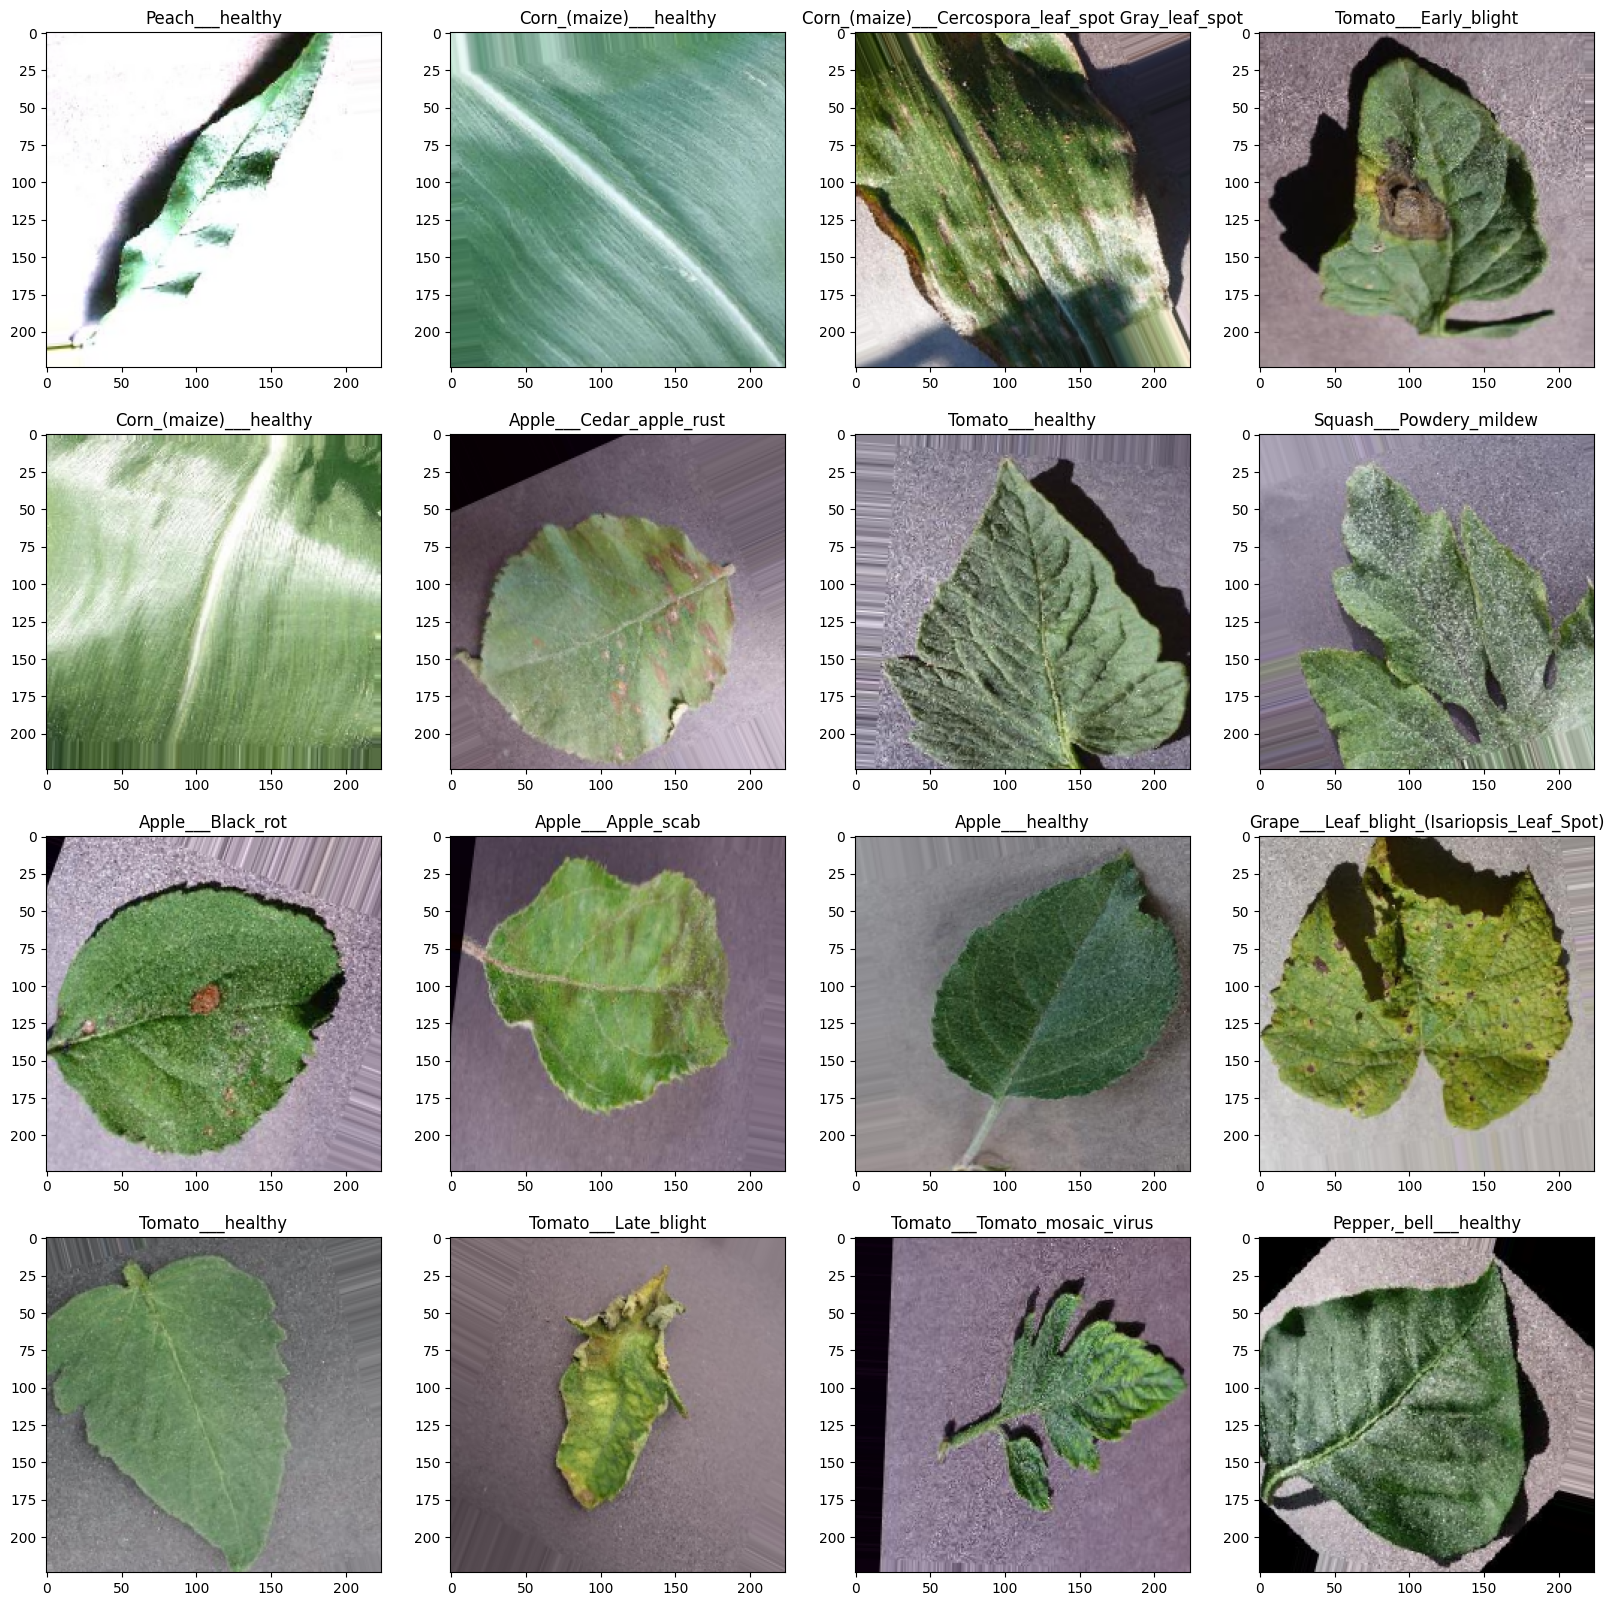

In [9]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [10]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset='validation',shuffle=False)

Found 7013 images belonging to 38 classes.


In [11]:
X_test=[]
for folder in os.listdir(test_dir):
    files=gb.glob(test_dir+'/*.JPG')
    for file in files :
        img=cv.imread(file)
        X_test.append(cv.resize(img,(Size,Size)))

In [12]:
X_test=np.array(X_test)
print(X_test.shape)

(1089, 224, 224, 3)


In [13]:
X_test=X_test/255.0

In [14]:
import keras
from keras.layers import Flatten , Dense , Dropout , BatchNormalization , MaxPooling2D ,Conv2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EarlyStop = EarlyStopping(patience=10, restore_best_weights=True)
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)
model_check = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)

callback = [EarlyStop, Reduce_LR, model_check]

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
model=Sequential([
                Conv2D(32,3,activation='relu',kernel_initializer='he_normal',input_shape=(Size,Size,3)),
                BatchNormalization(),
                MaxPooling2D(3),

                Conv2D(64,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),

                Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),

                Conv2D(256,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
#vgg19(include_top=False,input_shape=(Size,Size,3)),
                Flatten(),
                Dense(512,activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                BatchNormalization(),
                Dense(256,activation='relu'),
                Dropout(0.2),
                BatchNormalization(),
                Dense(38,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=10,batch_size=32,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.1664 - loss: 3.2944
Epoch 1: val_loss improved from inf to 4.51701, saving model to model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 94s 331ms/step - accuracy: 0.1667 - loss: 3.2929 - val_accuracy: 0.0093 - val_loss: 4.5170 - learning_rate: 0.0010
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3059 - loss: 2.4072
Epoch 2: val_loss improved from 4.51701 to 1.53107, saving model to model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 79s 321ms/step - accuracy: 0.3059 - loss: 2.4068 - val_accuracy: 0.4676 - val_loss: 1.5311 - learning_rate: 0.0010
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3739 - loss: 2.1712
Epoch 3: val_loss did not improve from 1.53107
247/247 ━━━━━━━━━━━━━━━━━━━━ 74s 300ms/step - accuracy: 0.3740 - loss: 2.1710 - val_accuracy: 0.1273 - val_loss: 3.2397 - learning_rate: 0.0010
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4166 - loss: 1.9829
Epoch 4: val_

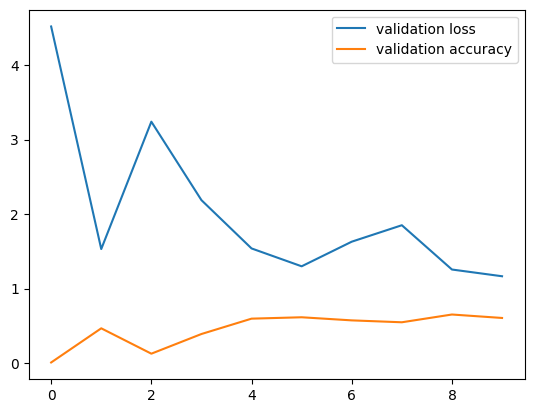

In [19]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [20]:


predictions=model.predict(valid_generator)



439/439 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step


In [21]:


from sklearn.metrics import classification_report
print(classification_report(valid_generator.classes, predictions.argmax(axis=1)))



              precision    recall  f1-score   support

           0       0.78      0.44      0.57       201
           1       0.78      0.77      0.78       198
           2       0.91      0.67      0.77       176
           3       0.75      0.59      0.66       200
           4       0.76      0.56      0.65       181
           5       0.79      0.85      0.82       168
           6       1.00      0.47      0.64       182
           7       0.75      0.41      0.53       164
           8       0.82      0.98      0.89       190
           9       0.79      0.93      0.85       190
          10       0.89      0.89      0.89       185
          11       0.85      0.34      0.49       188
          12       0.64      0.88      0.74       192
          13       0.64      0.93      0.76       172
          14       0.63      0.78      0.69       169
          15       0.83      0.85      0.84       201
          16       0.77      0.57      0.66       183
          17       0.95    

<Axes: >

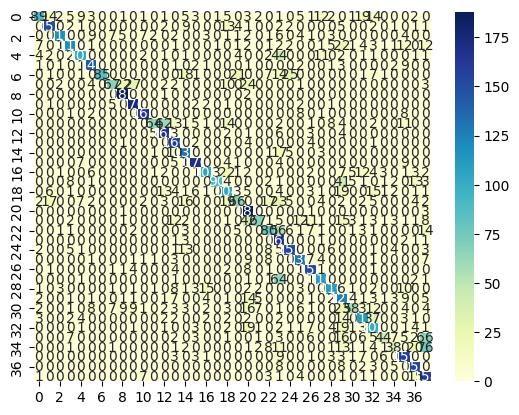

In [22]:


import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_generator.classes, predictions.argmax(axis=1))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")



<Axes: >

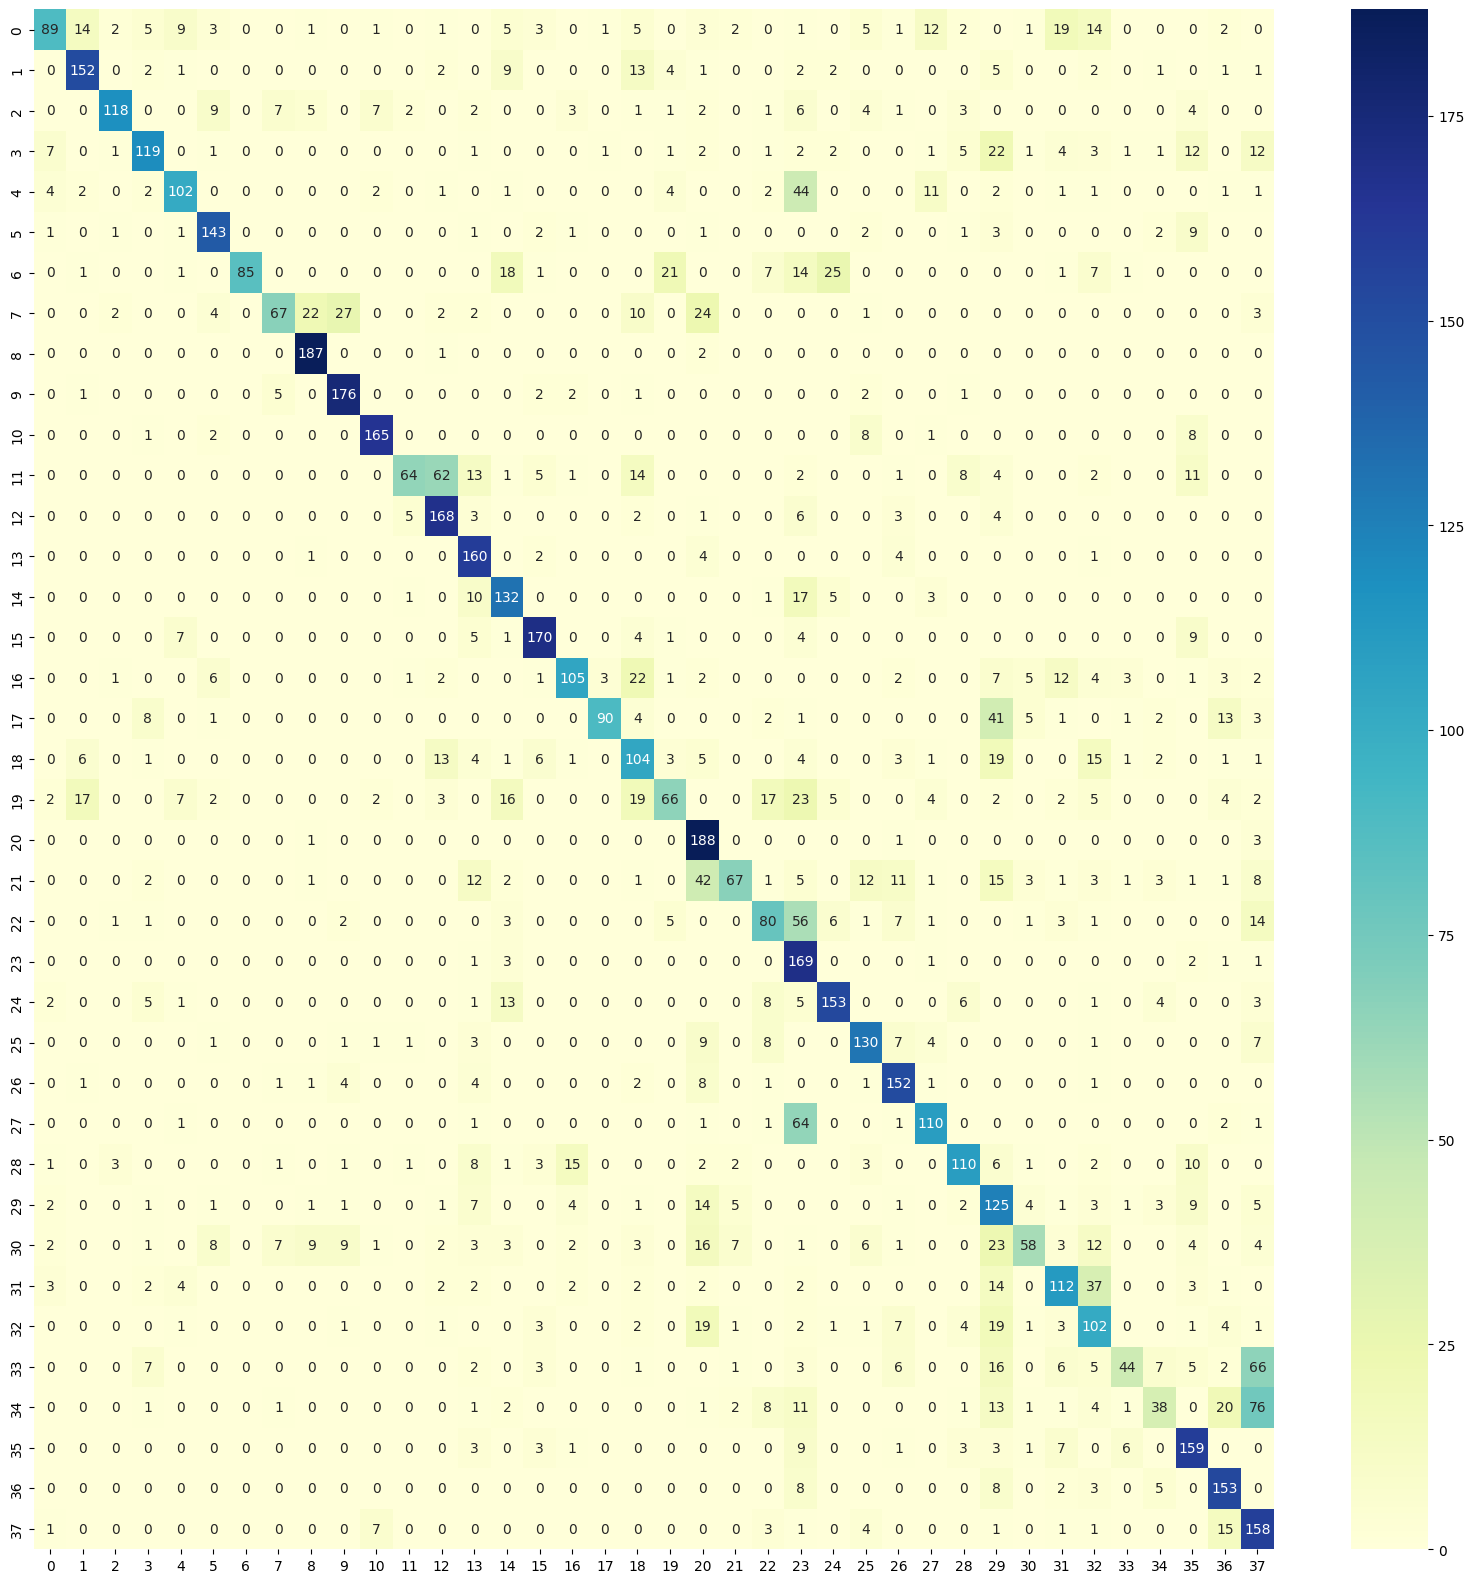

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [24]:
y_pred=model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


In [25]:
y_pred[0]

array([8.76772329e-02, 4.75231388e-07, 1.48560976e-05, 5.54695010e-01,
       2.57861539e-04, 2.59114075e-02, 2.25402982e-06, 4.00263234e-05,
       1.19955410e-04, 1.50015364e-06, 3.50034406e-06, 5.10875850e-07,
       1.15076500e-06, 2.10976509e-06, 1.34436346e-08, 2.30845120e-02,
       2.40296908e-02, 2.19756830e-03, 1.31799212e-07, 4.07483503e-06,
       8.36209438e-06, 4.51088526e-05, 1.70602505e-07, 3.79499397e-07,
       4.98846857e-05, 8.36996151e-06, 1.01723074e-07, 6.74202784e-06,
       2.58999341e-03, 2.92537664e-03, 3.96676362e-03, 2.34360144e-01,
       1.49315765e-05, 1.40754867e-03, 1.30750166e-04, 9.33993317e-04,
       2.23634604e-04, 3.52839008e-02], dtype=float32)

In [26]:
predictions=y_pred.argmax(axis=1)

In [27]:
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [28]:
predictions

array([ 3, 12, 12, ...,  3, 22, 36])

In [29]:
predictions[0]

np.int64(3)

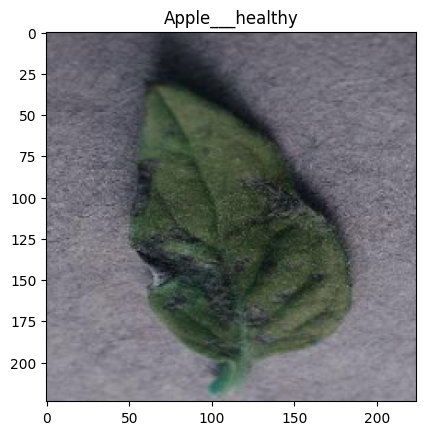

In [30]:


plt.imshow(X_test[0])
plt.title(classes[predictions[0]])
plt.show()



In [31]:
# Save the entire model to HDF5 file
model.save('plant_disease_model.h5')